# Example Notebook for a pipeline

## 1. libraries

In [1]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from sam_ml.models import RFC, Pipeline
from sam_ml.data import Embeddings_builder, Sampler, Scaler, Selector

## 2. data

### 2.1. load dataset

In [2]:
df = load_iris()
y = pd.Series(df.target)
X = pd.DataFrame(df.data, columns=df.feature_names)
x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.80, random_state=42)

In [3]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
# Flowers: Setosa (= 0), Versicolor (= 1) and Virginica (= 2)
y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

### 2.2. data preparation 
[not needed because already included in the pipeline]

## 3. model

All **Classifier** class methods apply also for Pipelines!!!

### 3.1. create pipeline

Every sam_ml Pipeline consists of 5 steps (4 data preparation + 1 model):

**vectorizer**: *Embeddings_builder* class object
- auto detects string columns and creates for every string column a vectorizer that vectorizes the columns
- to one-hot-encode a string column is equal to vectorizing it

**scaler**: *Scaler* class object
- scales the data

**selector**: *Selector* class object
- selectes features

**sampler**: *Sampler* class object
- up-/downsamples the data in training

**model**: *Classifier* subclass object
- predicts

for an easier use of pipelines, you can also just insert a string with the type of the vectorizer/scaler/selector/sampler instead of giving a class object. In this case, the default class object of this type will be used. If you insert **None**, the step will be skipped in the pipeline

In [5]:
model = Pipeline(vectorizer=None, scaler="minmax", selector=Selector(algorithm="kbest", num_features=3), sampler="ros", model=RFC(), model_name="pipy")

get the possible strings to enter with the **params** function from the data classes

In [6]:
print(Embeddings_builder.params())
print(Scaler.params())
print(Selector.params()) # algorithm parameter
print(Sampler.params())

{'vec': ['bert', 'count', 'tfidf']}
{'scaler': ['standard', 'minmax', 'maxabs', 'robust', 'normalizer', 'power', 'quantile', 'quantile_normal']}
{'algorithm': ['kbest', 'kbest_chi2', 'pca', 'wrapper', 'sequential', 'select_model', 'rfe', 'rfecv'], 'estimator': [LinearSVC(dual=False, penalty='l1'), LogisticRegression(), ExtraTreesClassifier(n_estimators=50)]}
{'algorithm': ['SMOTE', 'rus', 'ros', 'tl', 'nm']}


you can use the **steps** attribute to get the components of the pipeline. 

**Note:** the model information will be given as tuple consisting of the sklearn model, the model_type and the hyperparameter tuning grid

In [7]:
model.steps

[('vectorizer', None),
 ('scaler', <sam_ml.data.scaler.Scaler at 0x7f937da29af0>),
 ('selector', <sam_ml.data.feature_selection.Selector at 0x7f937da29160>),
 ('sampler', <sam_ml.data.sampling.Sampler at 0x7f937da29700>),
 ('model',
  (RandomForestClassifier(n_jobs=-1, random_state=42),
   'RFC',
   {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200, 500, 1000],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 15],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']}))]

### 3.2. simple training

train and evaluate your pipeline

In [8]:
model.train(x_train, y_train)
model.evaluate(x_test, y_test)

started training...
Train score:  1.0  - Train time:  0:00:00
accuracy:  1.0
precision:  [1. 1. 1.]
recall:  [1. 1. 1.]
s_score:  0.9926004570086354
l_score:  1.0

classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



{'accuracy': 1.0,
 'precision': array([1., 1., 1.]),
 'recall': array([1., 1., 1.]),
 's_score': 0.9926004570086354,
 'l_score': 1.0}

get the importance of the different features of your model

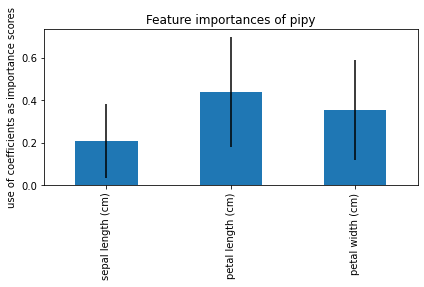

In [9]:
model.feature_importance()

predict with your model

In [10]:
test_df = pd.DataFrame([[1.3, 1.3, 1.3, 1.3], [6.5, 1.6, 8.6, 2.4]], columns=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'])
test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,1.3,1.3,1.3,1.3
1,6.5,1.6,8.6,2.4


In [11]:
model.predict(test_df)

[0, 2]

### 3.3. hyperparameter tuning

The default type of hyperparameter tuning is the *RandomizedSearchCV*; however, with the **rand_search** parameter in the **gridsearch** method you can change it to *GridSearchCV*. (it is recommended to use *RandomizedSearchCV* because it does not take so much time)

you can get the hyperparameter tuning grid as followed:

In [12]:
model.grid

{'model__n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200, 500, 1000],
 'model__max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 15],
 'model__min_samples_split': [2, 3, 5, 10],
 'model__min_samples_leaf': [1, 2, 4],
 'model__bootstrap': [True, False],
 'model__criterion': ['gini', 'entropy']}

you can change the hyperparameter tuning grid as followed:

to add parameters for the different steps, you have to use the following preffixes:

*vectorizer__*

*scaler__*

*selector__*

*sampler__*

*model__*

In [13]:
model.update_grid(selector__k = [1,2,3,4])

In [14]:
model.grid

{'selector__k': [1, 2, 3, 4],
 'model__n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200, 500, 1000],
 'model__max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 15],
 'model__min_samples_split': [2, 3, 5, 10],
 'model__min_samples_leaf': [1, 2, 4],
 'model__bootstrap': [True, False],
 'model__criterion': ['gini', 'entropy']}

simple scoring with recall/precision/accurracy

In [15]:
model.gridsearch(x_train, y_train, scoring="recall", avg="macro", train_afterwards=True)
model.evaluate(x_test, y_test, avg="macro")

grid:  {'selector__k': [1, 2, 3, 4], 'model__n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200, 500, 1000], 'model__max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 15], 'model__min_samples_split': [2, 3, 5, 10], 'model__min_samples_leaf': [1, 2, 4], 'model__bootstrap': [True, False], 'model__criterion': ['gini', 'entropy']}

starting hyperparameter tuning...
... hyperparameter tuning finished

mean: 0.931111 (stdev: 0.073221) with: {'selector__k': 4, 'model__n_estimators': 1000, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_depth': 4, 'model__criterion': 'entropy', 'model__bootstrap': False}
mean: 0.931296 (stdev: 0.068786) with: {'selector__k': 1, 'model__n_estimators': 64, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_depth': 3, 'model__criterion': 'gini', 'model__bootstrap': True}
mean: 0.934815 (stdev: 0.064501) with: {'selector__k': 3, 'model__n_estimators': 32, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_dep

{'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 's_score': 0.9926004570086354,
 'l_score': 1.0}

advanced scoring with s_score/l_score:
- **secondary_scoring** and **pos_label** to priorities metrics/classes in optimization
- **strength** to set how much the priorization is compared to scores in all the other metrics/classes
- always includes all metrics/classes and punishes really bad scores in one metric/class

In [16]:
model.gridsearch(x_train, y_train, scoring="s_score", train_afterwards=True, secondary_scoring="recall", pos_label=-1, strength=4)
model.evaluate(x_test, y_test, avg="macro", secondary_scoring="recall", pos_label=-1, strength=4)

grid:  {'selector__k': [1, 2, 3, 4], 'model__n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200, 500, 1000], 'model__max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 15], 'model__min_samples_split': [2, 3, 5, 10], 'model__min_samples_leaf': [1, 2, 4], 'model__bootstrap': [True, False], 'model__criterion': ['gini', 'entropy']}

starting hyperparameter tuning...
... hyperparameter tuning finished

mean: 0.817999 (stdev: 0.265367) with: {'selector__k': 4, 'model__n_estimators': 1000, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_depth': 4, 'model__criterion': 'entropy', 'model__bootstrap': False}
mean: 0.807910 (stdev: 0.269266) with: {'selector__k': 1, 'model__n_estimators': 64, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_depth': 3, 'model__criterion': 'gini', 'model__bootstrap': True}
mean: 0.861364 (stdev: 0.187150) with: {'selector__k': 3, 'model__n_estimators': 32, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_dep

{'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 's_score': 0.9816036781135836,
 'l_score': 1.0}

### 3.4. cross validation

#### 3.4.1. all-vs-one cross validation

**Concept:**

The model will be trained on all datapoints except one and then tested on this last one. This will be repeated for all datapoints so that we have our predictions for all datapoints.

**Advantage:** optimal use of information for training

**Disadvantage:** long train time

This concept is very useful for small datasets (datapoints < 150) because the long train time is still not too long and especially with a small amount of information for the model, it is important to use all the information one has for the training.

In [17]:
model.cross_validation_small_data(X, y, avg="macro")

starting to cross validate...


pipy: 100%|██████████| 150/150 [00:02<00:00, 51.25it/s]

... cross validation completed

classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.94      0.96        50
           2       0.94      0.98      0.96        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



{'accuracy': 0.9733333333333334,
 'precision': 0.9738247863247862,
 'recall': 0.9733333333333333,
 's_score': 0.9894085490834833,
 'l_score': 0.9999999893463261,
 'avg train score': 0.9734222222222223,
 'avg train time': '0:00:00'}

#### 3.4.2. multiple split cross validation

In [18]:
model.cross_validation(X, y, cv_num=5, avg="macro")

starting to cross validate...
... cross validation completed

                                0         1         2         3         4  \
fit_time                 0.023468  0.017522  0.021925  0.023937  0.021231   
score_time               0.010181  0.011443  0.013307  0.011746  0.012636   
test_precision (macro)   1.000000  1.000000  0.500000  0.916667  1.000000   
train_precision (macro)  0.973825  0.955000  1.000000  0.969948  0.956522   
test_recall (macro)      1.000000  1.000000  0.450000  0.950000  1.000000   
train_recall (macro)     0.973333  0.955000  1.000000  0.972222  0.980000   
test_accuracy            1.000000  1.000000  0.900000  0.933333  1.000000   
train_accuracy           0.966667  0.950000  1.000000  0.975000  0.975000   
test_s_score             0.997527  0.995061  0.002459  0.984473  0.997527   
train_s_score            0.989409  0.986459  0.992600  0.989121  0.986704   
test_l_score             1.000000  1.000000  0.000000  0.999980  1.000000   
train_l_score 

{'accuracy': 0.9666666666666666,
 'precision': 0.8833333333333334,
 'recall': 0.8800000000000001,
 's_score': 0.7954096415208831,
 'l_score': 0.7999959011044497,
 'avg train score': 0.9733333333333333,
 'avg train time': '0:00:00'}

### 3.5. save and load pipelines

save your pipeline class object with **only_estimator**=False or you can only save the sklearn model with **only_estimator**=True

In [19]:
model.save_model(path="pipy.pkl", only_estimator=False)

saving started...
... model saved


every *Model* subclass (*Classifier*, *Pipeline*, *RFC*, ...) has the *load_model* function that returns the model

In [20]:
loaded_model = Pipeline.load_model(path="pipy.pkl")

loading model...
... model loaded
